In [1]:
# import packages and files

import h5py
import numpy as np
from pathlib import Path

import matplotlib.pyplot as plt
plt.style.use('default')
plt.rcParams.update({
        "axes.linewidth": 2, "xtick.major.width": 2, "ytick.major.width": 2})
import matplotlib.colors as colors

from __future__ import annotations
from pyhipp import plot
from pyhipp.core import DataDict

from pyccb import samples
from pyccb.process.halo_web import HaloWebCross
from pyccb.process import ab_matching
from pyccb.process import calc_zw

SAMPLE_PATH = Path('/Volumes/T7/halo_web')  # Path in local

BASE_PATH = Path('/Volumes/T7/TNG100-1-Dark')
OUTPUT_PATH = Path('/Volumes/T7/halo_web')
CONFIG_FILE = OUTPUT_PATH / 'tng100-1-dark.json'
DENSITY_FILE = OUTPUT_PATH / 'density_field_s2.hdf5'  

N_grid = 256
file_halo_sample = SAMPLE_PATH / 'halo_sample.hdf5'
file_tidal_field = SAMPLE_PATH / 'field_sample_s2.hdf5'
dir_output = SAMPLE_PATH / 'output'

with h5py.File(file_tidal_field, 'r', locking=False) as f:
    print(f.keys())

<KeysViewHDF5 ['delta_sm_x', 'l_box', 'lambda_th', 'lams', 'n_grids']>


In [2]:
binary_filename = OUTPUT_PATH / 'density_field_256.bin'
expected_dtype = np.float32

print(f"--- Checking density field file: {binary_filename} ---")

try:
    data_1d = np.fromfile(binary_filename, dtype=expected_dtype)
    print(f"Read {data_1d.size} values.")
    expected_size = N_grid * N_grid * N_grid
    print(f"Expected number of values: {expected_size}")

    if data_1d.size != expected_size:
        print("\nFatal Error: The number of values in the file does not match the expected grid size!")
    else:
        field = data_1d.reshape((N_grid, N_grid, N_grid))
        nan_count = np.isnan(field).sum()
        if nan_count > 0:
            print("Warning: Your input data contains invalid values!")

        mean_val = np.mean(field)
        std_val = np.std(field)
        min_val = np.min(field)
        max_val = np.max(field)
        
        print("\n Stats：")
        print(f"    - Mean: {mean_val:.6f}")
        print(f"    - Std Dev: {std_val:.6f}")
        print(f"    - Min: {min_val:.6f}")
        print(f"    - Max: {max_val:.6f}")


except FileNotFoundError:
    print(f"Error: File '{binary_filename}' not found.")
except ValueError as e:
    print(f"\nFatal Error: Reshaping array failed - {e}. This usually indicates an incorrect file size.")

--- Checking density field file: /Volumes/T7/halo_web/density_field_256.bin ---
Read 16777216 values.
Expected number of values: 16777216

 Stats：
    - Mean: 359.228455
    - Std Dev: 6036.620117
    - Min: 2.344444
    - Max: 3087455.250000


Keys in the file: ['delta_sm_x', 'l_box', 'lambda_th', 'lams', 'n_grids']


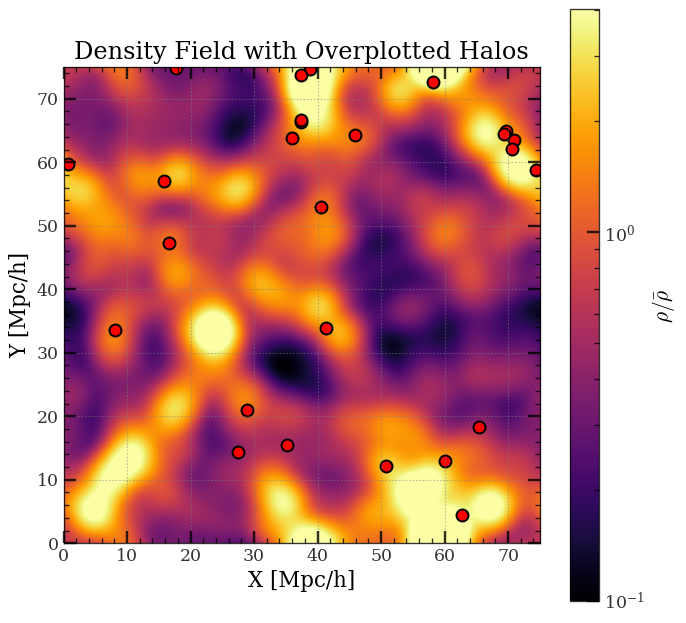

In [3]:
# plot field slice

slice_index =  128  # Choose a slice from the middle of the box (0 to 255)
slice_thickness = 5 # Number of slices to average over for a thicker projection

# --- Load Data ---
field_plot = h5py.File(file_tidal_field, 'r', locking=False)
print(f"Keys in the file: {list(field_plot.keys())}")
delta_sm_x = np.array(field_plot['delta_sm_x'])
l_box = np.array(field_plot['l_box'])
n_grids = np.array(field_plot['n_grids'])

# --- Create Projection ---
# Averaging a few slices can make features clearer
slice_data = np.mean(delta_sm_x[:, :, slice_index : slice_index + slice_thickness], axis=2)

# --- Load Halo Data ---
with h5py.File(file_halo_sample, 'r', locking=False) as f:
    halo_pos = f['position'][:]
    halo_mass = f['mass'][:]

# Select massive halos to make the plot cleaner
mass_cut = np.quantile(halo_mass, 0.95) # Plot the most massive 5% of halos
massive_halos_pos = halo_pos[halo_mass > mass_cut]

# --- Select halos within the plotted slice ---
z_min = slice_index * l_box / n_grids
z_max = (slice_index + slice_thickness) * l_box / n_grids
in_slice_mask = (massive_halos_pos[:, 2] >= z_min) & (massive_halos_pos[:, 2] < z_max)
halos_in_slice = massive_halos_pos[in_slice_mask]

# --- Plotting ---
fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow((1 + slice_data).T, origin='lower', extent=[0, l_box, 0, l_box],
               cmap='inferno', norm=colors.LogNorm(vmin=0.1, vmax=(1 + delta_sm_x.max())/10))

# Overplot halo positions
ax.scatter(halos_in_slice[:, 0], halos_in_slice[:, 1], 
           edgecolors='black', s=80, lw=1.5, facecolors='red')

ax.set_title(f'Density Field with Overplotted Halos')
ax.set_xlabel('X [Mpc/h]')
ax.set_ylabel('Y [Mpc/h]')
fig.colorbar(im, ax=ax, label=r'$\rho / \bar{\rho}$')
plt.show()

Keys in the field file: ['delta_sm_x', 'l_box', 'lambda_th', 'lams', 'n_grids']


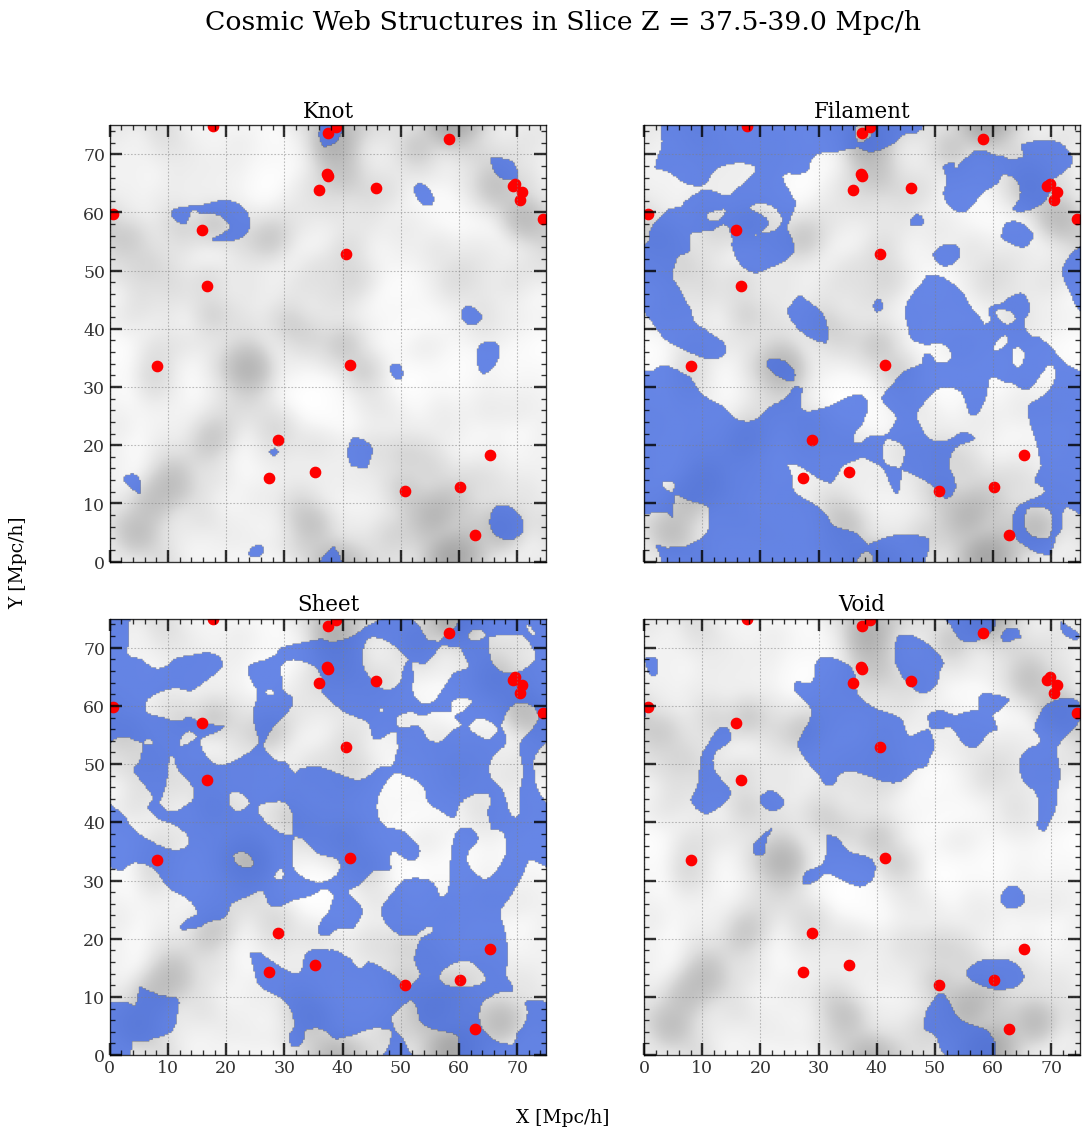

In [16]:
slice_index = 128  
slice_thickness = 5 

with h5py.File(file_tidal_field, 'r', locking=False) as f:
    print(f"Keys in the field file: {list(f.keys())}")
    lams = f['lams'][:]
    delta_sm_x = f['delta_sm_x'][:]
    l_box = f['l_box'][()]
    n_grids = f['n_grids'][()]
    lambda_th = f['lambda_th'][()]


web_type_grid = (lams > lambda_th).sum(axis=-1)
slice_data_density = np.mean(delta_sm_x[:, :, slice_index : slice_index + slice_thickness], axis=2)

with h5py.File(file_halo_sample, 'r') as f:
    halo_pos = f['position'][:]
    halo_mass = f['mass'][:]

mass_cut = np.quantile(halo_mass, 0.95)
massive_halos_pos = halo_pos[halo_mass > mass_cut]

z_min = slice_index * l_box / n_grids
z_max = (slice_index + slice_thickness) * l_box / n_grids
in_slice_mask = (massive_halos_pos[:, 2] >= z_min) & (massive_halos_pos[:, 2] < z_max)
halos_in_slice = massive_halos_pos[in_slice_mask]

fig, axs = plt.subplots(2, 2, figsize=(12, 12), sharex=True, sharey=True)
axs = axs.flatten()

web_types = {
    'Knot': 3,
    'Filament': 2,
    'Sheet': 1,
    'Void': 0
}

for ax, (name, type_code) in zip(axs, web_types.items()):
    mask = (web_type_grid == type_code)
    slice_mask = mask[:, :, slice_index:slice_index + slice_thickness].any(axis=2)

    ax.imshow((1 + slice_data_density).T, origin='lower', extent=[0, l_box, 0, l_box],
              cmap='Greys', norm=colors.LogNorm(vmin=0.1, vmax=100), alpha=0.5)

    cmap_web = colors.ListedColormap(['none', 'royalblue'])
    ax.imshow(slice_mask.T, origin='lower', extent=[0, l_box, 0, l_box],
                cmap=cmap_web, alpha=0.8)

    ax.scatter(halos_in_slice[:, 0], halos_in_slice[:, 1], 
                facecolors='red', edgecolors='red', s=60, lw=1.0)
    
    ax.set_title(name, fontsize=16)
    ax.set_aspect('equal')

fig.supxlabel('X [Mpc/h]', fontsize=14)
fig.supylabel('Y [Mpc/h]', fontsize=14)
fig.suptitle(f'Cosmic Web Structures in Slice Z = {z_min:.1f}-{z_max:.1f} Mpc/h', fontsize=20)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()



In [5]:
# plot vff vs lambda_th

from tqdm import tqdm

lambda_th_values = np.linspace(0, 1.0, 101)


def calculate_vff_vs_lambda(lams: np.ndarray, lambda_thresholds: np.ndarray) -> dict:
    vff_results = {
        'knot': [],
        'filament': [],
        'sheet': [],
        'void': []
    }
    
    total_cells = np.prod(lams.shape[:-1])

    for i, l_th in tqdm(enumerate(lambda_thresholds)):
        n_above_thresh = (lams > l_th).sum(axis=-1)
        
        vff_knot = np.sum(n_above_thresh == 3) / total_cells
        vff_filament = np.sum(n_above_thresh == 2) / total_cells
        vff_sheet = np.sum(n_above_thresh == 1) / total_cells
        vff_void = np.sum(n_above_thresh == 0) / total_cells
        
        vff_results['knot'].append(vff_knot)
        vff_results['filament'].append(vff_filament)
        vff_results['sheet'].append(vff_sheet)
        vff_results['void'].append(vff_void)

    for key in vff_results:
        vff_results[key] = np.array(vff_results[key])
        
    return vff_results



def plot_vff(lambda_thresholds: np.ndarray, vff_data: dict):
    fig, ax = plt.subplots(figsize=(8, 6))

    ax.plot(lambda_thresholds, vff_data['void'],     color='black', linestyle='-',  lw=2, label='void')
    ax.plot(lambda_thresholds, vff_data['sheet'],    color='black', linestyle='--', lw=2, label='sheet')
    ax.plot(lambda_thresholds, vff_data['filament'], color='black', linestyle=':',  lw=2, label='filament')
    ax.plot(lambda_thresholds, vff_data['knot'],     color='black', linestyle='-.', lw=2, label='knot')

    ax.set_xlabel(r'$\lambda_{th}$', fontsize=16)
    ax.set_ylabel('Volume Filling Fraction', fontsize=16)
    ax.set_title('Cosmic Web Volume Fractions at z=0 (TNG100-1-Dark)', fontsize=18)
    
    ax.set_xlim(0, 1.0)
    ax.set_ylim(0.0, 1.0)
    
    ax.tick_params(axis='both', which='major', labelsize=12, length=6, width=1.5)
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.legend(fontsize=14)
    
    plt.tight_layout()
    plt.show()

101it [00:11,  8.57it/s]


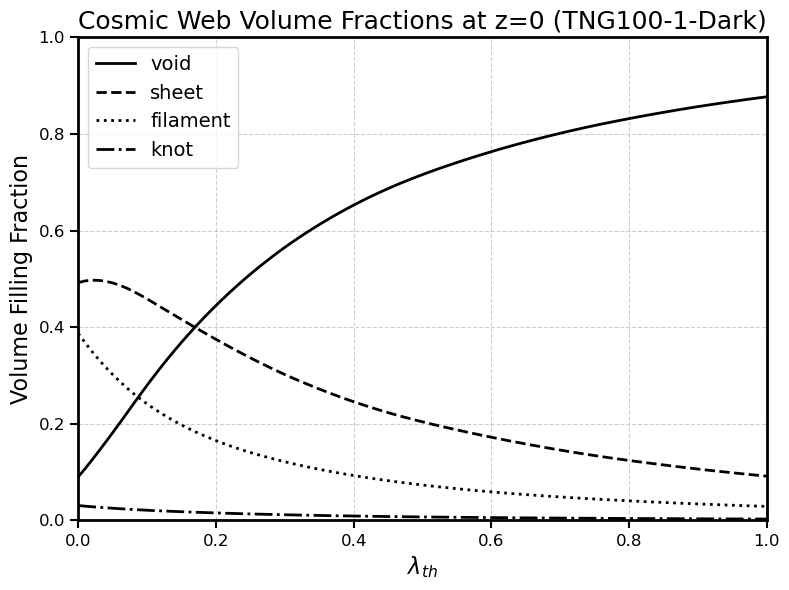

[0.03060466 0.02936846 0.02820569 0.02711183 0.0260796  0.02507836
 0.02414328 0.02326292 0.02244484 0.02165592 0.02092779 0.02023959
 0.01960641 0.01900321 0.01842928 0.0178737  0.01733893 0.01682431
 0.01632404 0.015836   0.01537561 0.01493615 0.0145089  0.01409924
 0.01370049 0.01332402 0.01294714 0.01259845 0.01225507 0.01191813
 0.0116033  0.01129842 0.01100296 0.0107094  0.01043314 0.01015651
 0.00989354 0.00964892 0.00941026 0.0091784  0.00895244 0.00872922
 0.00851178 0.00830507 0.0081079  0.00791842 0.00773215 0.00756037
 0.00738961 0.00723135 0.00707632 0.00692636 0.00677431 0.00663465
 0.00649112 0.00635374 0.00622505 0.00609779 0.00597507 0.00585389
 0.00573051 0.00561494 0.00550103 0.00538903 0.00528032 0.00517458
 0.00507158 0.00497031 0.00487334 0.00477797 0.00468469 0.00459409
 0.00450587 0.00441813 0.00433278 0.00424963 0.00416577 0.00408518
 0.00400841 0.00393379 0.00386143 0.00379354 0.00372779 0.00365978
 0.00359386 0.00353378 0.00347048 0.00340807 0.00334996 0.0032

In [19]:
with h5py.File(file_tidal_field, 'r', locking=False) as f:
    lams_data = f['lams'][:]

vff_results = calculate_vff_vs_lambda(lams_data, lambda_th_values)
plot_vff(lambda_th_values, vff_results)
print(vff_results['knot'])